## Importing dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import tensorflow as tf

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

## Initializing Variables

In [6]:
labels = ['PNEUMONIA', 'NORMAL']
img_dim = 100
img_size = img_dim * img_dim

## Helper Functions

In [7]:
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), 0)
                resized_arr = cv2.resize(img_arr, (img_dim, img_dim))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
def splitLabel(data):
    features = []
    labels = []
    for feature, label in data:
        features.append(feature)
        labels.append(label)
    return features, labels

In [9]:
def normalizeReshape(x, y):
    x = np.array(x) / 255
    x = x.reshape(-1, img_dim, img_dim, 1)
    y = np.array(y)
    return x, y

In [10]:
def dataAugmentation(data):
    new_aug = []
    for img in data:
        img_aug = transform(image=img)['image']
        new_aug.append(img_aug)
    new_aug = np.array(new_aug)
    return new_aug

In [11]:
def shuffleAugmentation(data, num):
    data_shuffled = data.copy()
    np.random.shuffle(data_shuffled)
    data_cut = data_shuffled[:num]
    data_aug = dataAugmentation(data_cut)
    return data_aug

In [12]:
def augment(data, folds, num):
    aug_concat = []
    for i in range(folds):
        aug = shuffleAugmentation(data, num)
        # aug_concat = np.concatenate((aug_concat, aug), axis=0)
        aug_concat.append(aug)
    aug_concat = np.array(aug_concat)
    shape = aug_concat.shape
    aug_concat = aug_concat.reshape(shape[0]*shape[1], img_dim, img_dim)
    return aug_concat

## Main code

#### loading data

In [13]:
train = get_training_data(r'F:\materials\third year\secondTerm\AI\Project\Dataset\DATASET\chest_xray\train')
test = get_training_data(r'F:\materials\third year\secondTerm\AI\Project\Dataset\DATASET\chest_xray\test')
val = get_training_data( r'F:\materials\third year\secondTerm\AI\Project\Dataset\DATASET\chest_xray\val')


In [14]:
# getting balanced data: normal = pneumonia 
normal_arr_train = []
pnemonia_arr_train = []
for i in train:
    if i[:][1]==0:
        pnemonia_arr_train.append([i[:][0],0])
    if i[:][1]==1:
        normal_arr_train.append([i[:][0],1])

pnemonia_arr_train = np.array(pnemonia_arr_train)
training_pneu = pnemonia_arr_train[:1341]
training_normal= np.array(normal_arr_train)
training_balanced = np.concatenate((training_pneu ,training_normal) , axis = 0) 
np.random.shuffle(training_balanced)

print(training_balanced.shape)

(2682, 2)


In [15]:
x_balanced_train , y_balanced_train = splitLabel(training_balanced)
x_balanced_train = np.array(x_balanced_train)
y_balanced_train = np.array(y_balanced_train)

print(x_balanced_train.shape)

(2682, 100, 100)


In [16]:
x_train, y_train = splitLabel(train)
x_val, y_val = splitLabel(val)
x_test, y_test = splitLabel(test)
x_train_balanced, y_train_balanced = splitLabel(training_balanced)

#### data count visualization

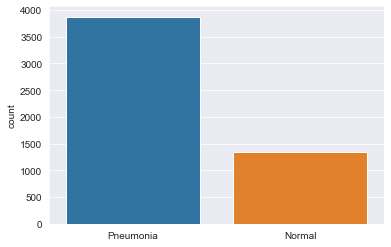

In [17]:
l = []
normal = []
pneumonia = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
        pneumonia.append(i[0])
    else:
        l.append("Normal")
        normal.append(i[0])
sns.set_style('darkgrid')
sns.countplot(l)
plt.savefig('skewed_data.png')

In [18]:
print('Pneumonia count: ', l.count('Pneumonia'), ', Normal count: ', l.count('Normal'))
print('ratio of P/N = ', 3875/1341)

Pneumonia count:  3875 , Normal count:  1341
ratio of P/N =  2.889634601043997


In [19]:
normal = np.array(normal)
pneumonia = np.array(pneumonia)
print(normal.shape, pneumonia.shape)

(1341, 100, 100) (3875, 100, 100)


#### data augmentation

In [20]:
import albumentations as A

transform = A.Compose(
    [A.CLAHE(),
     A.RandomRotate90(),
     A.Transpose(),
     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50,
                        rotate_limit=45, p=.75),
     A.Blur(blur_limit=3),
     A.OpticalDistortion(),
     A.GridDistortion(),
     A.HueSaturationValue()])

In [21]:
normal_augmented = augment(normal, 2, 1200)
normal_new = np.concatenate((normal, normal_augmented), axis=0)
print(normal_new.shape)
np.random.shuffle(normal_new)

(3741, 100, 100)


In [22]:
x_train_new = np.concatenate((pneumonia, normal_new), axis=0)
y0 = np.zeros(l.count('Pneumonia'))
y1 = np.ones(normal_new.shape[0])
y_train_new = np.concatenate((y0, y1), axis=0)

print(x_train_new.shape, y_train_new.shape)

(7616, 100, 100) (7616,)


#### data normalization and reshaping

In [110]:
x_train, y_train = normalizeReshape(x_train_new, y_train_new)
x_val, y_val = normalizeReshape(x_val, y_val)
x_test, y_test = normalizeReshape(x_test, y_test)
# x_train_balanced, y_train_balanced = normalizeReshape(x_train_balanced, y_train_balanced)

(7616, 100, 100, 1) (7616,)


In [25]:
xMod_val = x_val.reshape(16, img_size)
xMod_test = x_test.reshape(624, img_size)

In [26]:
print(x_train.shape)
# print(x_train_balanced.shape)
print(x_val.shape)
print(x_test.shape)

(7616, 100, 100, 1)
(16, 100, 100, 1)
(624, 100, 100, 1)


#### feature extraction

(7616, 10000)


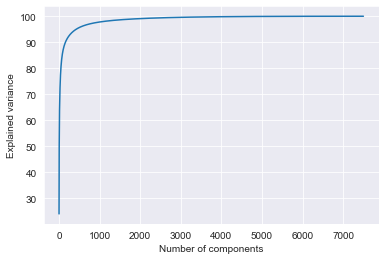

In [72]:
from sklearn.decomposition import PCA
xMod = x_train.reshape(x_train.shape[0], img_size)
print(xMod.shape)
pca_7500 = PCA(n_components=7500)
pca_7500.fit(xMod)


plt.grid('on')
plt.plot(np.cumsum(pca_7500.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('pca_components_plot.png')

Text(0.5, 1.0, 'Compressed image with 1000 components')

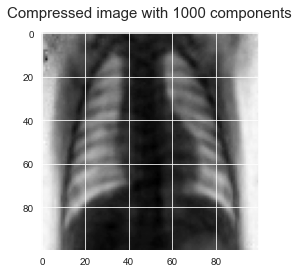

In [91]:
components = 1000
pca_1000 = PCA(n_components=components)
xMod_pca_1000_reduced = pca_1000.fit_transform(xMod)
xMod_pca_1000_recovered = pca_1000.inverse_transform(xMod_pca_1000_reduced)

image_pca_1000 = xMod_pca_1000_recovered[1,:].reshape([img_dim,img_dim])
plt.imshow(image_pca_1000, cmap='gray_r')
plt.title('Compressed image with ' + str(components) + ' components', fontsize=15, pad=15)


In [92]:
x_val_pca_reduced = pca_1000.transform(xMod_val)
x_test_pca_reduced = pca_1000.transform(xMod_test)


In [93]:
np.cumsum(pca_1000.explained_variance_ratio_ * 100)[-1]

97.76204535237433

#### Classifier: SVM

In [94]:
from sklearn.svm import SVC

svm_clf = SVC(C=0.5 , probability = True , decision_function_shape = 'ovo')
xMod_pca_1000_reduced
svm_clf.fit(xMod_pca_1000_reduced, y_train)


SVC(C=0.5, decision_function_shape='ovo', probability=True)

In [95]:
print("train score = ", svm_clf.score(xMod_pca_1000_reduced, y_train))
print("val score = ", svm_clf.score(x_val_pca_reduced, y_val))
print("test score = ", svm_clf.score(x_test_pca_reduced, y_test))


train score =  0.9810924369747899
val score =  0.75
test score =  0.7836538461538461


plotting ROC curve

In [96]:
print(y_test.shape)
y_scores = svm_clf.predict_proba(x_test_pca_reduced)
y_decision_func = np.array(svm_clf.decision_function(x_test_pca_reduced))


(624,)


auc score  0.9193732193732194


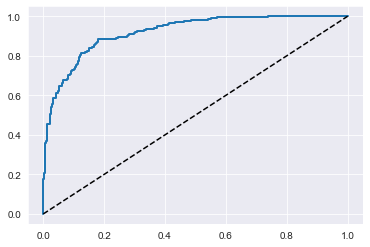

In [97]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
     # Add axis labels and grid
print("auc score " , roc_auc_score(y_test, y_scores[:,1]))

plot_roc_curve(fpr, tpr)
plt.show()

### Classifier: Logistic Regression

In [107]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(random_state=0)

logistic_clf.fit(xMod_pca_1000_reduced, y_train)


LogisticRegression(random_state=0)

In [108]:
print("train score = ", logistic_clf.score(xMod_pca_1000_reduced, y_train))
print("val score = ", logistic_clf.score(x_val_pca_reduced, y_val))
print("test score = ", logistic_clf.score(x_test_pca_reduced, y_test))

train score =  0.9709821428571429
val score =  0.875
test score =  0.7467948717948718


**ROC for logistic regression**

auc score  0.8231974578128424


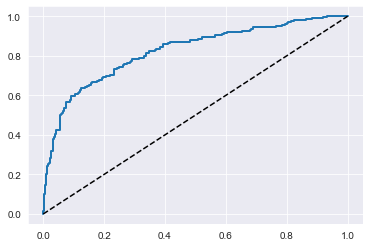

In [109]:
y_scores = logistic_clf.predict_proba(x_test_pca_reduced)
y_decision_func = np.array(logistic_clf.decision_function(x_test_pca_reduced))

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal

    # Add axis labels and grid
print("auc score ", roc_auc_score(y_test, y_scores[:, 1]))

plot_roc_curve(fpr, tpr)
plt.show()


### Classifier: KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3)

knn_clf.fit(xMod_pca_1000_reduced, y_train)


KNeighborsClassifier(n_neighbors=3)

In [89]:
print("train score = ", knn_clf.score(xMod_pca_1000_reduced, y_train))
print("val score = ", knn_clf.score(x_val_pca_reduced, y_val))
print("test score = ", knn_clf.score(x_test_pca_reduced, y_test))


train score =  0.9600840336134454
val score =  0.625
test score =  0.7660256410256411


**ROC for KNN**

auc score  0.8075279421433267


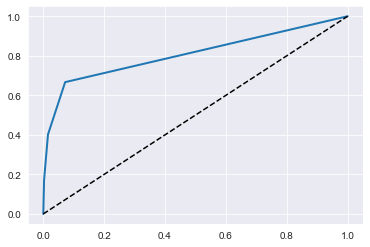

In [90]:
y_scores = knn_clf.predict_proba(x_test_pca_reduced)
# y_decision_func = np.array(knn_clf.decision_function(x_test_pca_reduced))

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal


    # Add axis labels and grid
print("auc score ", roc_auc_score(y_test, y_scores[:, 1]))

plot_roc_curve(fpr, tpr)
plt.show()


#### Classifier: Ensemble Learning
Voting classifiers method &rarr; KNN, SVM, and Logistic regression

trying ensemble learning, voting classifiers method 
we wil use KNN, logistic regression and SVM classifiers

In [62]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [63]:
log_clf = LogisticRegression(max_iter=500)
svm_ens = SVC(C=0.3)
neigh = KNeighborsClassifier(n_neighbors=1)

In [111]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('knn', neigh), ('svc', svm_ens) ],
    voting='hard' 
)
voting_clf.fit(xMod_pca_1000_reduced, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=500)),
                             ('knn', KNeighborsClassifier(n_neighbors=1)),
                             ('svc', SVC(C=0.3))])

In [112]:
print("train score = ", voting_clf.score(xMod_pca_1000_reduced, y_train))
print("val score = ", voting_clf.score(x_val_pca_reduced, y_val))
print("test score = ", voting_clf.score(x_test_pca_reduced, y_test))


train score =  0.992515756302521
val score =  0.8125
test score =  0.7756410256410257


#### Classifier: Ensemble Learning
Voting classifiers method &rarr; KNN, SVM, Logistic regression, and Gradient Boosting

In [113]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [114]:
log_clf = LogisticRegression(max_iter=500)
svm_ens = SVC(C=0.3)
neigh = KNeighborsClassifier(n_neighbors=1)
GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [115]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('knn', neigh), ('svc', svm_ens), ('gb' , GB)],
    voting='hard'
)
voting_clf.fit(xMod_pca_1000_reduced, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=500)),
                             ('knn', KNeighborsClassifier(n_neighbors=1)),
                             ('svc', SVC(C=0.3)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=1.0,
                                                         max_depth=1,
                                                         random_state=0))])

In [117]:
print("train score = ", voting_clf.score(xMod_pca_1000_reduced, y_train))
print("val score = ", voting_clf.score(x_val_pca_reduced, y_val))
print("test score = ", voting_clf.score(x_test_pca_reduced, y_test))


train score =  0.9866071428571429
val score =  0.75
test score =  0.7580128205128205
